Dr. Jesús Martí Gavilá. Departamento de Ingeniería Cartográfica, Geodesia y fotogrametría
<font color="blue" ><h1 align=center>PRÁCTICA 10</h1> <p> <h1 align=center> EJERCICIO PRÁCTICO CON GOOGLE EARTH ENGINE PARA PYTHON</h1></font>

<a href="http://www.upv.es/titulaciones/GTI/indexc.html"><img src = "http://www.upv.es/imagenes/marcaUPVN1.png" width =200 ></a>

<h2 align=center>Grado Tecnologías Interactivas | Tecnologías de la Información Geográfica</h2>


<div class="alert alert-block alert-info" style="margin-top: 20px">
 <b><H2>OBJETIVOS</h2></b>  <div align="justify">Utilizar la plataforma de Google Earth Engine donde el alumno, de forma autónoma, obtenga los valores del Indice Medioambiental asignado, en función de dos constelaciones de satélites y sea plasmado en una WebMapping</div>
<h2>Resultados:</h2>   
    <ul>
        <li>Crear un WebMapping con los resultados de los índices cálculados </li>
        <li>Exportar las imágenes en formato Geotiff a Drive, de la zona de estudio</li>
    </ul>


<h2><font color="blue" >Librerías y Activación GEE</font></h2><p>

Cargar las librerías necesarias y activar la plataforma de GEE en la que previamenete el usuario deberá haberse registrado (solo se realiza una única vez por maquina)

In [2]:
import folium
from folium import plugins
import ee
import branca
import branca.colormap as cm
ee.Authenticate()
ee.Initialize()

In [3]:
# Función de GEE predefinida para añadir capas con Folium

def add_ee_layer (self, ee_imagen, parametros, nombre):
    map_id = ee.Image(ee_imagen).getMapId(parametros)
    folium.raster_layers.TileLayer(
        tiles=map_id['tile_fetcher'].url_format, 
        attr = 'ALUMNOS......Tecnologias de la Informacion Geografica', #Indicar el nombre de los componentes del grupo
        name = nombre,
        overlay = True, # Permite la superposición
        control = True # Permite que aparezca la capa o no en el layer control
        ).add_to(self)

# Con esto creamos un método propio llamado addLayer que llamara a la función add_ee_layer
folium.Map.addLayer = add_ee_layer

In [4]:
# Leyenda
colormap = cm.StepColormap(['red','yellow','green','blue'], index=[-1,-0.3,0,0.2,1],vmin=-1, vmax=1, max_labels=5,caption='Valores del NDWI y MNDWI',tick_labels=[])

# mapa.add_child(colormap) ............Utilizar esta expresión para añadir la rampa al mapa
colormap

<h1 align=center><font color="green" >Estudio de Indices de AGUA con Google Earth Engine.</font></h1><p>
    
<h2 align=center> Caso de estudio </h2><p>
<h4 align=center> 
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------</h4>

<div align="justify"> </div>El método Índice de agua de diferencia normalizada (NDWI, por sus siglas en inglés) es un índice que sirve para definir y monitorizar los cambios de contenido en aguas superficiales. 


<h2><font color="red" >TAREA 1</font></h2><p>
<h3> Calcular el Indice con imágenes satélite de la plataformas correspondiente al grupo asignado</h3> <p>
Se calculará el Indice con las imágenes satélite de 2 plataformas para un periodo de tiempo establecido y un lugar de estudio, en función del grupo de estudio asignado.<p>
Se realizará un WebMap con las 2 capas resultantes, aplicando la rampa de colores índicada anteriormente y se exportará en formato Geotiff, al Drive del grupo, las imagenes correspondientes a las zonas de estudio indicadas.
<p><h3 align=center> Índice de Agua de Diferencia Normalizada (NDWI). McFeeters, 1996</h3> <p><p>
<h3 align=center>Índice de Agua de Diferencia Normalizada Modificado (MNDWI). Xu, 2006</h3><p>

<h2 align=center>Valores rampa de colores</h2>


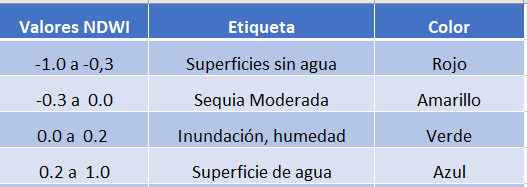

In [25]:
import folium
from folium import plugins
import ee
import branca
import branca.colormap as cm
ee.Authenticate()
ee.Initialize()

# Colección de imágenes de Sentinel con una nubosidad inferior al 20% y la medía calculada de los pixels
sentinel= (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                  .filterDate('2024-06-03', '2024-09-03')
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)).mean()) #el filtro de nubosidad varía según imagen

landsat= (ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
                  .filterDate('2024-06-15', '2024-09-15')
                  .filter(ee.Filter.lt('CLOUD_COVER',20)).mean())

def NDWI(image):
    # Definir la expresión para el NDWI
    NDWI = image.expression(
        'float((GREEN - NIR) / (GREEN + NIR))', 
        {
            'NIR': image.select("SR_B5").multiply(0.0000275).add(-0.2),
            'GREEN': image.select("SR_B3").multiply(0.0000275).add(-0.2),
        }
    )
    return NDWI

def NDWI_Sentinel(image):
    NDWI = image.expression(
        'float((GREEN - NIR) / (GREEN + NIR))',
        {
            'GREEN': image.select("B3"),  # Banda verde en Sentinel-2
            'NIR': image.select("B8")     # Banda NIR en Sentinel-2
        }
    )
    return NDWI


ndwi_sentinel = NDWI_Sentinel(sentinel)
ndwi_landsat = NDWI(landsat)


geometry = ee.Geometry.Rectangle([-0.40, 38.8, -0.20, 39.0])

task_config1 = { 
    'image': ndwi_sentinel, 
    'description': 'NDWI_Sentinel2', 
    'folder': 'NDWI_Results', 
    'fileNamePrefix': 'NDWI_Sentinel2', 
    'scale': 30, 
    #'region': region_geometry, 
}

task_config2 = {
    'image': ndwi_landsat, 
    'description': 'NDWI_Landsat9', 
    'folder': 'NDWI_Results', 
    'fileNamePrefix': 'NDWI_Landsat9', 
    'scale': 30, 
    #'region': region_geometry, 
    'maxPixels': 1e13 
}

ee.batch.Export.image.toDrive(**task_config1).start()
ee.batch.Export.image.toDrive(**task_config2).start()



# Ejemplo aplicación de intervalos a imagenes.
sld_intervalos = """
    <RasterSymbolizer>
        <ColorMap type="intervals" extended="false" >
            <ColorMapEntry color="#ff0000" quantity="-0.3" label="SUPERFICIES SIN AGUA"/>
            <ColorMapEntry color="#ffff00" quantity="0" label="SEQUIA MODERADA" />
            <ColorMapEntry color="#00ff00" quantity="0.2" label="INUNDACIÓN,HUMEDAD" />
            <ColorMapEntry color="#0000ff" quantity="1" label="SUPERFICIE DE AGUA" />
            
        </ColorMap>
    </RasterSymbolizer>"""


# Crear y añadir elementos al mapa
mapa_intervalo = folium.Map(location=[23.6345, -102.5528], zoom_start=12)
mapa_intervalo.addLayer(ndwi_sentinel.sldStyle(sld_intervalos),None,'SLD intervalos 8')
mapa_intervalo.addLayer(ndwi_landsat.sldStyle(sld_intervalos),None,'SLD intervalos 9')
folium.LayerControl().add_to(mapa_intervalo)
mapa_intervalo.add_child(legend)
mapa_intervalo
